In [1]:
import pandas as pd
from sodapy import Socrata
from IPython.display import display
import gmplot
import requests
from bs4 import BeautifulSoup
from pprint import pprint
from config import gkey
import re
import numpy as np
import gmaps
%matplotlib inline

Since we are looking at county level data in Connecticut, caching some county information. 
1. Use BeautifulSoup to get the list of counties in Connecticut from Wikipedia
2. Use Google geocode to get latitude and longitude information for each county.
This information will be used later to generate a heatmap.

In [2]:
wiki = "https://en.wikipedia.org/wiki/List_of_counties_in_Connecticut"
req = requests.get(wiki)
soup = BeautifulSoup(req.text,"lxml")
table = soup.find("table", { "class" : "wikitable sortable" })

In [3]:
counties_list = []
for row in table.findAll("tr"):
    cells = row.findAll("td")
    if cells:
        county = cells[0].find(text=True)
        county = re.sub("County","",county).title().rstrip()
        counties_list.append(county)
counties_list

['Fairfield',
 'Hartford',
 'Litchfield',
 'Middlesex',
 'New Haven',
 'New London',
 'Tolland',
 'Windham']

In [4]:
geo_location = {county:{} for county in counties_list}
for county in counties_list:
    target_url = f"https://maps.googleapis.com/maps/api/geocode/json?" \
            f"address={county} county,CT&key={gkey}"
    try:
        geo_data = requests.get(target_url).json() 
        lat = geo_data["results"][0]["geometry"]["location"]["lat"]
        lng = geo_data["results"][0]["geometry"]["location"]["lng"]
    except Exception as exp:
        print(f"ERROR2:{exp}, {geo_data}")
        lat = ""
        lng = ""
    geo_location[county]["lat"] = lat
    geo_location[county]['lng'] = lng
    
pprint(geo_location)

{'Fairfield': {'lat': 41.2559654, 'lng': -73.37086959999999},
 'Hartford': {'lat': 41.7924343, 'lng': -72.8042797},
 'Litchfield': {'lat': 41.7866294, 'lng': -73.2765361},
 'Middlesex': {'lat': 41.46985050000001, 'lng': -72.4731529},
 'New Haven': {'lat': 41.3266911, 'lng': -72.8042797},
 'New London': {'lat': 41.5185189, 'lng': -72.0468164},
 'Tolland': {'lat': 41.8418987, 'lng': -72.37846789999999},
 'Windham': {'lat': 41.8275622, 'lng': -72.0468164}}


Getting Drug Death related information from CT, and cleaning up (removing rows which do not have county information.
TODO: Get county information from the city information

In [5]:
client = Socrata("data.ct.gov", None)

In [6]:
results = client.get("u2qy-687x")

In [7]:
# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)

In [8]:
results_df.head()

,:@computed_region_dam5_q64j,:@computed_region_m4y2_whse,:@computed_region_nhmp_cq6b,:@computed_region_snd5_k6zv,age,amphet,any_opioid,benzo_s,casenumber,coc,...,morphine_not_heroin,other,oxyc,oxym,race,residence_city,residence_county,residence_state,sex,tramad
0,1045,59,243,8,53,NaN,NaN,Y,13-16336,NaN,...,NaN,NaN,Y,Y,White,GROTON,NEW LONDON,NaN,Female,NaN
1,1044,151,167,4,30,NaN,NaN,NaN,12-18447,Y,...,NaN,NaN,Y,NaN,White,WOLCOTT,NEW HAVEN,NaN,Male,NaN
2,1041,49,108,1,43,NaN,NaN,Y,14-2758,NaN,...,NaN,NaN,NaN,NaN,White,ENFIELD,NaN,NaN,Male,NaN
3,1044,148,195,7,24,NaN,NaN,NaN,14-13497,NaN,...,NaN,NaN,NaN,NaN,White,WALLINGFORD,NaN,NaN,Female,NaN
4,1044,156,11,7,26,NaN,NaN,NaN,13-14421,NaN,...,NaN,NaN,NaN,NaN,White,WEST HAVEN,NEW HAVEN,NaN,Female,NaN


In [9]:
results_df.columns

Index([':@computed_region_dam5_q64j', ':@computed_region_m4y2_whse',
       ':@computed_region_nhmp_cq6b', ':@computed_region_snd5_k6zv', 'age',
       'amphet', 'any_opioid', 'benzo_s', 'casenumber', 'coc', 'date',
       'death_city', 'death_county', 'death_state', 'deathloc',
       'deathloc_city', 'deathloc_state', 'etoh', 'fentanyl', 'heroin',
       'hydr_cod', 'immediatecausea', 'injuryplace', 'location',
       'mannerofdeath', 'methadone', 'morphine_not_heroin', 'other', 'oxyc',
       'oxym', 'race', 'residence_city', 'residence_county', 'residence_state',
       'sex', 'tramad'],
      dtype='object')

In [10]:
results_df['death_county'] = results_df.death_county.str.title()

In [11]:
results_df = results_df.dropna(subset=['death_county'])

In [12]:
target_url = f"https://maps.googleapis.com/maps/api/geocode/json?" \
            f"address=Hartford,CT,USA&key={gkey}"
try:
    geo_data = requests.get(target_url).json() 
    CT_lat = geo_data["results"][0]["geometry"]["location"]["lat"]
    CT_lng = geo_data["results"][0]["geometry"]["location"]["lng"]
except:
    print ("Cannot find geocode for Hartford")

Generate a google heatmap for the density of deaths by location.

In [13]:
gmap = gmplot.GoogleMapPlotter(CT_lat,CT_lng,10)

In [14]:
gmap

In [15]:
def get_geocode(row):
    place = row["death_county"]
    try:
        row["lat"] = geo_location[place]["lat"]
        row['lng'] = geo_location[place]["lng"]
    except:
        print (f"Cannot find {place} in CT counties, {row.name}.")
        row["lat"] = np.nan
        row["lng"] = np.nan
    return row

In [16]:
results_df = results_df.apply(get_geocode,axis=1)
#results_df["lng"] = results_df.apply(get_geolng, axis=1)
results_df = results_df.dropna(subset=['lat','lng'])

Cannot find Usa in CT counties, 243.


In [17]:
gmap.heatmap(results_df.lat, results_df.lng)
gmap.draw("my_heatmap.html")

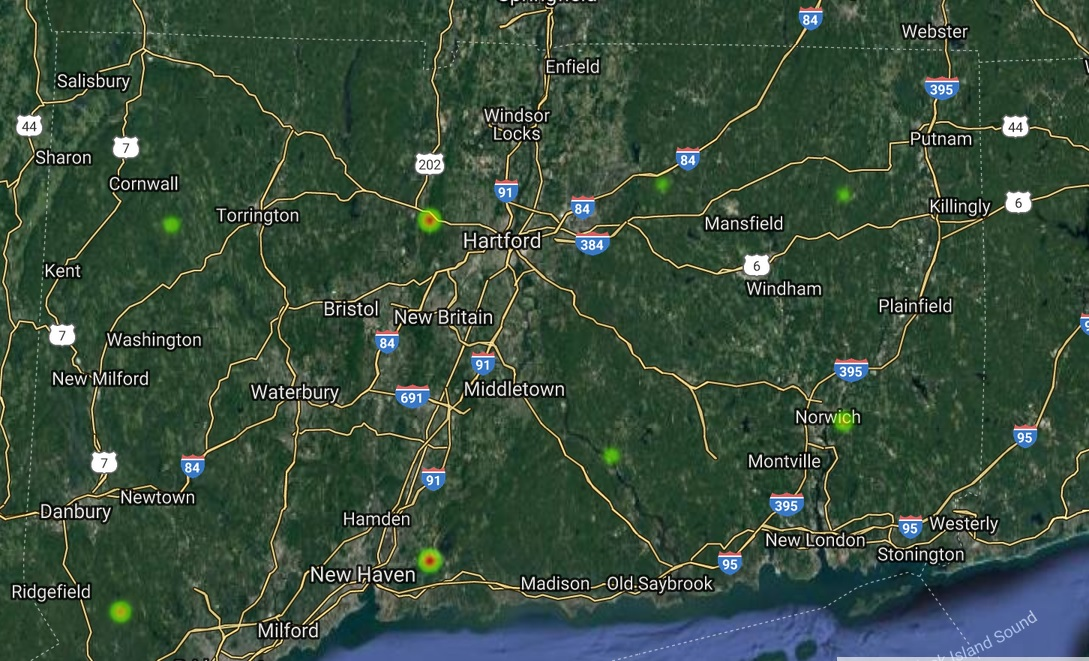

In [18]:
from IPython.display import Image
Image("county_heatmap_google.jpg")

In [19]:
results_df[results_df["death_county"] == "USA"]

,:@computed_region_dam5_q64j,:@computed_region_m4y2_whse,:@computed_region_nhmp_cq6b,:@computed_region_snd5_k6zv,age,amphet,any_opioid,benzo_s,casenumber,coc,...,oxyc,oxym,race,residence_city,residence_county,residence_state,sex,tramad,lat,lng


In [20]:
zip(results_df.lat, results_df.lng)

In [21]:
gmap_data = list(zip(results_df.lat, results_df.lng))


In [22]:
gmaps.configure(api_key=gkey)
fig = gmaps.figure(map_type='HYBRID')
heatmap_layer = gmaps.heatmap_layer(gmap_data)
#heatmap_layer.gradient = ['white','silver','gray']
fig.add_layer(heatmap_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [23]:
# import matplotlib.pyplot as plt
# from mpl_toolkits.basemap import Basemap
# import basemap

In [24]:
import folium
from folium import plugins

In [25]:
fmap_heat = folium.Map([CT_lat, CT_lng], zoom_start=8,control_scale = True,tiles="Mapbox Bright")

In [26]:
fmap_heat.add_child(plugins.HeatMap(list(zip(results_df.lat, results_df.lng))))
fmap_heat
                                                 

In [27]:
from collections import Counter

In [28]:
death_counts = Counter(results_df["death_county"])
death_counts

Counter({'New London': 106,
         'New Haven': 270,
         'Fairfield': 146,
         'Hartford': 245,
         'Middlesex': 46,
         'Litchfield': 48,
         'Tolland': 26,
         'Windham': 28})

In [29]:
df = pd.DataFrame.from_dict(death_counts, orient='index').reset_index()
df = df.rename(columns={'index':'County',0:'Num Deaths'})
df

,County,Num Deaths
0,New London,106
1,New Haven,270
2,Fairfield,146
3,Hartford,245
4,Middlesex,46
5,Litchfield,48
6,Tolland,26
7,Windham,28


In [30]:
state_geo = "tl_2010_09_county10.json"
fmap = folium.Map([CT_lat, CT_lng], zoom_start=8,control_scale = True,tiles="Mapbox Bright")
fmap.choropleth(
 geo_data=state_geo,
 name='choropleth',
 data=df,
 columns=['County','Num Deaths'],
 key_on='feature.properties.NAME10',
 fill_color='PuRd',
 fill_opacity=0.7,
 line_opacity=0.2,
 legend_name='Drug Mortality'
)
folium.LayerControl().add_to(fmap)
 
# Save to html
fmap.save('county_choropleth_folium.html')
fmap

In [31]:
import json
json_data=open(state_geo).read()

jdata = json.loads(json_data)
pprint(jdata.keys())

dict_keys(['type', 'features'])


In [32]:
pprint(jdata['features'][0]['properties'])

{'ALAND10': 1618456437,
 'AWATER10': 549162331,
 'CBSAFP10': '14860',
 'CLASSFP10': 'H4',
 'COUNTYFP10': '001',
 'COUNTYNS10': '00212794',
 'CSAFP10': '408',
 'FUNCSTAT10': 'N',
 'GEOID10': '09001',
 'INTPTLAT10': '+41.2281028',
 'INTPTLON10': '-073.3667574',
 'LSAD10': '06',
 'METDIVFP10': '',
 'MTFCC10': 'G4020',
 'NAME10': 'Fairfield',
 'NAMELSAD10': 'Fairfield County',
 'STATEFP10': '09'}


In [33]:
pprint([d['properties']['NAME10'] for d in jdata['features'] ])

['Fairfield',
 'New London',
 'Litchfield',
 'Windham',
 'Tolland',
 'Hartford',
 'Middlesex',
 'New Haven']
